# Only the image feature extraction using the CNN encoder

## Process the bottleneck stage in advance
## Pickle the 2048 features
## Doing this for each of my 5k image subsets created from the 118287 total train images

## COMMON PART FOR ALL SUBSETS features *extraction*

In [1]:
import os
import sys
import json
import time
import datetime
import string
import pandas as pd
import numpy as np
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import re
import pickle
#import itertools
from sklearn.model_selection import train_test_split
import PIL
import PIL.Image

In [2]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/gdrive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [3]:
OPDIR = '/content/gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoTrain2017_1/'
IPDIRANNO = '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_annotations_trainval2017/'

### Create "descriptions" dictionary

In [4]:
os.listdir(IPDIRANNO)

['captions_val2017.json', 'captions_train2017.json', 'sample_data_in_file.txt']

In [5]:
## from the annotations file, load the captions

with open(IPDIRANNO+'captions_train2017.json', 'r') as f:
  data = json.load(f)
  #data.keys() # dict_keys(['info', 'licenses', 'images', 'annotations'])
  #type(data['annotations']) # is a list
  #type(data['images'])      # also is a list

dfanno = pd.DataFrame(data=data['annotations'])
# dfanno.columns = Index(['image_id', 'id', 'caption'], dtype='object') 
# dfanno.dtypes =
#   image_id     int64
#   id           int64
#   caption     object
#   dtype: object

dfimages = pd.DataFrame(data=data['images'])
# dfimages.columns = Index(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'], dtype='object')
# dfimages.dtypes =
#   license           int64
#   file_name        object
#   coco_url         object
#   height            int64
#   width             int64
#   date_captured    object
#   flickr_url       object
#   id                int64
#   dtype: object
## of above, am dropping useless columns
dfimages.drop(['license', 'coco_url', 'date_captured', 'flickr_url'], axis = 1, inplace=True)

## columns remaining in the dfs are:
# dfanno columns are      image_id , id , caption
#                         179765   , 38 ,	A black Honda motorcycle parked in front of a ...
# dfimages columns are    file_name        , height ,  width , id
#                         000000397133.jpg , 427    ,  640   , 397133

## the captions are not ordered for each image and seem to be randomly placed

dfanno.head(3)

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...


In [6]:
## marrying the "annotations" and the "images" keys info together into dfanno
## the file_name column has the actual image name from the "image" key section
dfanno = dfanno.merge(dfimages, how="inner", left_on='image_id', right_on='id')
dfanno.drop(['height', 'width', 'id_y'], axis = 1, inplace=True)
dfanno.rename(columns={'id_x':'id'}, inplace=True)
dfanno.head(3)

,image_id,id,caption,file_name
0,203564,37,A bicycle replica with a clock as the front wh...,000000203564.jpg
1,203564,181,The bike has a clock as a tire.,000000203564.jpg
2,203564,478,A black metal bicycle with a clock inside the ...,000000203564.jpg


In [7]:
## Mapping image with captions using dictionary

def create_descriptions_dictionary(_dfin):
    descriptions = {}
    for row in _dfin.itertuples():
      rowdict = row._asdict()
      img_filename = rowdict['file_name'].split('.')[0] # drop the .jpg part
      img_caption = rowdict['caption']
      if(img_filename not in descriptions):
        descriptions[img_filename] = [img_caption]
      else:
        descriptions[img_filename].append(img_caption)
    return descriptions

descriptions = create_descriptions_dictionary(dfanno)

In [8]:
## stopping here and no further clearning being done as am only interested in the image feature extraction for now

### Data Preprocessing — Images
### Make Inception-v3 pre-trained model. Use it to create image feature vectors. Finally pickle for reloading

In [9]:
## Make images suitable for use by Inception-v3 model later
##
## Resize to (299, 299)
## As model needs 4-dim input tensor, add one dimenion to make it (1, 299, 299, 3)
## Preprocess the image using custom function of Inception-v3 model

In [10]:
def preprocess_image_for_Incepv3(_img_path, _key = 'DUMMY', _DEBUG=False):
  img = tf.keras.preprocessing.image.load_img(_img_path, target_size=(299, 299))
  #print(f"type={type(img)}") # type(img): type=<class 'PIL.Image.Image'>
  if _DEBUG:
    plt.figure(figsize=(12,6))
    plt.subplot(121)
    plt.imshow(img)
    plt.title('Original Image(Resized): ' + _key + '.jpg')

  img = tf.keras.preprocessing.image.img_to_array(img) # Converts PIL Image instance to numpy array (299,299,3)
  img = np.expand_dims(img, axis=0) #Add one more dimension: (1, 299, 299, 3) # Inception-V3 requires 4 dimensions
  img = tf.keras.applications.inception_v3.preprocess_input(img) # preprocess image as per Inception-V3 model
  if _DEBUG:
    plt.subplot(122)
    plt.imshow(img[0])
    plt.title('Preprocessed image for Inception-V3: ' + _key + '.jpg')

  return img  # shape will be (1, 299, 299, 3)

In [11]:
### Load pre-trained model of Inception-v3 pretrained on Imagenet
### Then, Encode images into feature vectors and save it to disk
###
### Doing this in advance so that the feature vector representation of images is already available. Will drastically speed up training

In [12]:
#Load pre-trained model and remove the last layer (Output layer)

# Load Inception-V3 model
model_inception_v3_pretrained_imagement = tf.keras.applications.InceptionV3(weights='imagenet')

# Create new model, by removing last layer (output layer) from Inception-V3
model_CNN_encoder = keras.Model(inputs=model_inception_v3_pretrained_imagement.input, outputs=model_inception_v3_pretrained_imagement.layers[-2].output)

#model_CNN_encoder.summary()

96116736/96112376 [==============================] - 1s 0us/step


In [13]:
## Take each image and run it through the encoder. The feature of each image is a numpy array of 2048 values.
## 
## Store all the info image-wise into a dict with image name as key, the 2048 features as the value.
##       E.g. of an entry
##            print(len(img_encodings['000000179765'])) = 
##                                                         {'000000179765': array([0.14290829, 0.14481416, 0.3019989 , ..., 0.20583093, 0.13783988,
##                                                         0.05842407], dtype=float32), '000000190236': array([0.13693394, 0.44518015, 0.8012958 , ..., 0.09661996, 0.5428589 ,
##                                                         0.12551732], dtype=float32)}
## 
## Bottleneck processing. For 5k images took around 40 minutes.
##       So pickle for later use

In [14]:
# Function to encode given image into a vector of size (2048, )
def encode_image(_imgpath, _key = 'DUMMY', _DEBUG=False):
    preproc_img = preprocess_image_for_Incepv3(_imgpath, _key = 'DUMMY', _DEBUG=False) # preprocess image per Inception-v3 requirements
    encoded_features = model_CNN_encoder.predict(preproc_img) # Get encoding vector for image
    encoded_features = encoded_features.reshape(encoded_features.shape[1], ) # reshape from (1, 2048) to (2048, )
    return encoded_features

In [15]:
type(model_CNN_encoder)

tensorflow.python.keras.engine.functional.Functional

## Process the 5000 - 10000 subset - DONE - DO NOT EDIT

In [ ]:
!ls '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/'

coco_test2017_subset_0_5000	  COCO_train2017_118k
coco_test2017_subset_10000_15000  Rishabh_DO_NOT_TOUCH_PLS_1
coco_test2017_subset_15000_20000  train2017.zip
coco_test2017_subset_5000_10000


In [ ]:
IPDIRIMGS = '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_5000_10000/'
ONE_RANDOM_IMAGE = '000000001554'   ## do not put the .jpg
os.path.isfile(''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg']))

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image path = /content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_5000_10000/000000001554.jpg
Shape after preprocessing = (1, 299, 299, 3)


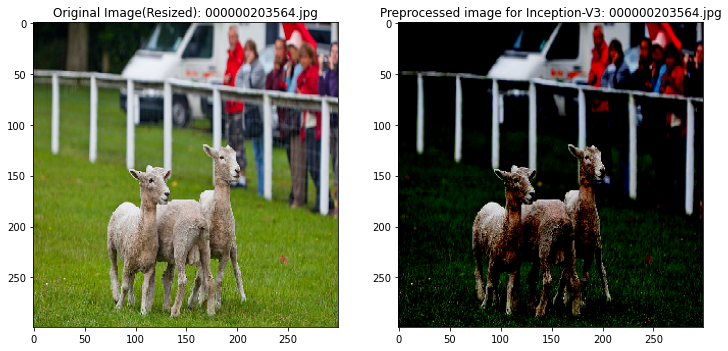

In [ ]:
## test out the preprocessing function on one image
##     while calling fuction set debug flag to true to display the original and preprocessed images
i = 0
for key in descriptions.keys():   ## key is the image name itself without the .jpg
  if i > 0:
    break
  
  imgpath = ''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg'])
  #imgpath = ''.join([IPDIRIMGS, key, '.jpg'])
  print(f"Image path = {imgpath}")
  preproc_img = preprocess_image_for_Incepv3(imgpath, _key=key, _DEBUG=True)
  print(f"Shape after preprocessing = {preproc_img.shape}")
  i += 1

In [ ]:
descriptions[ONE_RANDOM_IMAGE]

['Three sheep in a pasture with people standing by the fence.',
 'Goats play in the grass while spectators watch. ',
 'Three sheared sheep on grass facing different directions.',
 'Three little goats attract the attention of a group of people at an outdoor display.',
 'A herd of sheep walking across a field of grass.']

### NOTE: Changed code to check if the file exists coz
### description dict is from the full annotations data
### but i split the images into 5k subsets

In [ ]:
os.path.isfile(''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg']))

True

In [ ]:
## verify count found = 5000
found = 0
for key in descriptions.keys():
  if os.path.isfile(''.join([IPDIRIMGS, key, '.jpg'])) :
    found += 1
print(found)

5000


In [ ]:
## actually encode the images and capture entries in dictionary with key as the filename only without the full path or the .jpg extension
##     using same key as the hashmap for captions uses

## sending all the images
start_time = time.time()
print(f"Started at: {datetime.datetime.now().strftime('%H:%M:%S')}")
img_encodings = {}
idx = 0
for img_filename_only in descriptions.keys():
  if False:  ## debugging
    if idx > 1:
      break
  if os.path.isfile(''.join([IPDIRIMGS, img_filename_only, '.jpg'])):
    img_encodings[img_filename_only] = encode_image(''.join([IPDIRIMGS, img_filename_only, '.jpg']))
    idx += 1
    if idx % 200 == 1:
      print(f'Count of images encoded = {idx}')

print(f"Encoded {idx} images; total time taken = {time.time()-start_time} seconds")

Started at: 22:12:15
Count of images encoded = 1
Count of images encoded = 201
Count of images encoded = 401
Count of images encoded = 601
Count of images encoded = 801
Count of images encoded = 1001
Count of images encoded = 1201
Count of images encoded = 1401
Count of images encoded = 1601
Count of images encoded = 1801
Count of images encoded = 2001
Count of images encoded = 2201
Count of images encoded = 2401
Count of images encoded = 2601
Count of images encoded = 2801
Count of images encoded = 3001
Count of images encoded = 3201
Count of images encoded = 3401
Count of images encoded = 3601
Count of images encoded = 3801
Count of images encoded = 4001
Count of images encoded = 4201
Count of images encoded = 4401
Count of images encoded = 4601
Count of images encoded = 4801
Encoded 5000 images; total time taken = 3243.094076395035 seconds


In [ ]:
len(img_encodings)  ## should be number of images i.e. 5000

5000

In [ ]:
OPDIR

'/content/gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoTrain2017_1/'

In [ ]:
## pickle the data
with open(OPDIR+'train2017_subset_5k_5000_10000_images_encoded_features_pickled_1.pkl', 'wb') as handle:
  pickle.dump(img_encodings, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Pickling done")

print(f"Size of pickled data = {sys.getsizeof(img_encodings)} bytes")

Pickling done
Size of pickled data = 147560 bytes


In [ ]:
img_encodings[ONE_RANDOM_IMAGE]

array([0.2147606 , 0.8954987 , 0.17155823, ..., 0.23975088, 0.25898552,
       0.40968645], dtype=float32)

In [ ]:
del img_encodings

In [ ]:
## reload from picked file
if True:
  with open(OPDIR+'train2017_subset_5k_5000_10000_images_encoded_features_pickled_1.pkl', 'rb') as handle:
    img_encodings = pickle.load(handle)

#img_encodings

In [ ]:
img_encodings[ONE_RANDOM_IMAGE]

array([0.2147606 , 0.8954987 , 0.17155823, ..., 0.23975088, 0.25898552,
       0.40968645], dtype=float32)

## Process the 10000 - 15000 subset - DONE - DO NOT EDIT

In [ ]:
!ls '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/'

coco_test2017_subset_0_5000	  COCO_train2017_118k
coco_test2017_subset_10000_15000  Rishabh_DO_NOT_TOUCH_PLS_1
coco_test2017_subset_15000_20000  train2017.zip
coco_test2017_subset_5000_10000


In [ ]:
IPDIRIMGS = '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_10000_15000/'
ONE_RANDOM_IMAGE = '000000001059'   ## do not put the .jpg
os.path.isfile(''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg']))

True

Image path = /content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_10000_15000/000000001059.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after preprocessing = (1, 299, 299, 3)


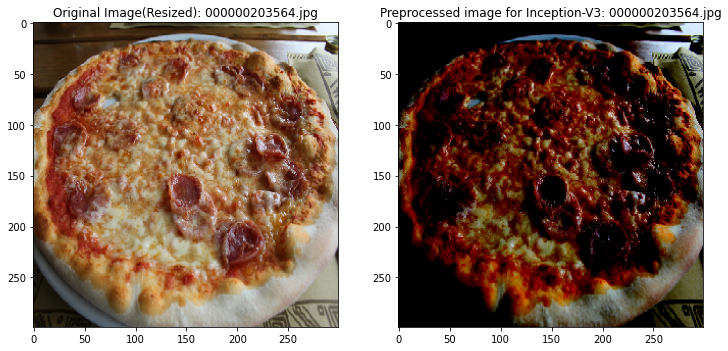

In [ ]:
## test out the preprocessing function on one image
##     while calling fuction set debug flag to true to display the original and preprocessed images
i = 0
for key in descriptions.keys():   ## key is the image name itself without the .jpg
  if i > 0:
    break
  
  imgpath = ''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg'])
  #imgpath = ''.join([IPDIRIMGS, key, '.jpg'])
  print(f"Image path = {imgpath}")
  preproc_img = preprocess_image_for_Incepv3(imgpath, _key=key, _DEBUG=True)
  print(f"Shape after preprocessing = {preproc_img.shape}")
  i += 1

In [ ]:
descriptions[ONE_RANDOM_IMAGE]

['A cheesy pepperoni pizza sitting on top of a pan.',
 'A pepperoni pizza on a plate sitting on a table.',
 'A small pizza that appears to have pepperonis on it.',
 'A pepperoni pizza with extra cheese and pale thick dough. ',
 'A pizza with pepperonis sitting on a plate on a table.']

### NOTE: Changed code to check if the file exists coz
### description dict is from the full annotations data
### but i split the images into 5k subsets

In [ ]:
os.path.isfile(''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg']))

True

In [ ]:
## verify count found = 5000
found = 0
for key in descriptions.keys():
  if os.path.isfile(''.join([IPDIRIMGS, key, '.jpg'])) :
    found += 1
print(found)

5000


In [ ]:
## actually encode the images and capture entries in dictionary with key as the filename only without the full path or the .jpg extension
##     using same key as the hashmap for captions uses

In [ ]:
## sending all the images
start_time = time.time()
print(f"Started at: {datetime.datetime.now().strftime('%H:%M:%S')}")
img_encodings = {}
idx = 0
for img_filename_only in descriptions.keys():
  if False:  ## debugging
    if idx > 1:
      break
  if os.path.isfile(''.join([IPDIRIMGS, img_filename_only, '.jpg'])):
    img_encodings[img_filename_only] = encode_image(''.join([IPDIRIMGS, img_filename_only, '.jpg']))
    idx += 1
    if idx % 200 == 1:
      print(f'Count of images encoded = {idx}')

print(f"Encoded {idx} images; total time taken = {time.time()-start_time} seconds")

Started at: 23:20:05
Count of images encoded = 1
Count of images encoded = 201
Count of images encoded = 401
Count of images encoded = 601
Count of images encoded = 801
Count of images encoded = 1001
Count of images encoded = 1201
Count of images encoded = 1401
Count of images encoded = 1601
Count of images encoded = 1801
Count of images encoded = 2001
Count of images encoded = 2201
Count of images encoded = 2401
Count of images encoded = 2601
Count of images encoded = 2801
Count of images encoded = 3001
Count of images encoded = 3201
Count of images encoded = 3401
Count of images encoded = 3601
Count of images encoded = 3801
Count of images encoded = 4001
Count of images encoded = 4201
Count of images encoded = 4401
Count of images encoded = 4601
Count of images encoded = 4801
Encoded 5000 images; total time taken = 3022.835025548935 seconds


In [ ]:
len(img_encodings)  ## should be number of images i.e. 5000

5000

In [ ]:
OPDIR

'/content/gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoTrain2017_1/'

In [ ]:
## pickle the data
with open(OPDIR+'train2017_subset_5k_10000_15000_images_encoded_features_pickled_1.pkl', 'wb') as handle:
  pickle.dump(img_encodings, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Pickling done")

print(f"Size of pickled data = {sys.getsizeof(img_encodings)} bytes")

Pickling done
Size of pickled data = 147560 bytes


In [ ]:
img_encodings[ONE_RANDOM_IMAGE]

array([0.01428782, 0.75508875, 0.        , ..., 1.1059809 , 0.43047294,
       0.30469653], dtype=float32)

In [ ]:
del img_encodings

In [ ]:
## reload from picked file
if True:
  with open(OPDIR+'train2017_subset_5k_10000_15000_images_encoded_features_pickled_1.pkl', 'rb') as handle:
    img_encodings = pickle.load(handle)

#img_encodings

In [ ]:
img_encodings[ONE_RANDOM_IMAGE]

array([0.01428782, 0.75508875, 0.        , ..., 1.1059809 , 0.43047294,
       0.30469653], dtype=float32)

## Process the 15000 - 20000 subset - ALREADY DONE in different notebook

## Pickle file: /content/gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoTrain2017_1/train2017_subset_5k_15000_20000_images_encoded_features_pickled_1.pkl

In [16]:
os.listdir(OPDIR)

['laptop_coco_train2017_listdir.pkl',
 'BKUP_laptop_coco_train2017_listdir.pkl.BKUP',
 'gdrive_coco_train2017_118287_listdir.pkl',
 'BKUP_gdrive_coco_train2017_118287_listdir (1).pkl.BKUP',
 'train2017_subset_5k_5000_10000_images_encoded_features_pickled_1.pkl',
 'BKUP_train2017_subset_5k_5000_10000_images_encoded_features_pickled_1.pkl.BKUP',
 'train2017_subset_5k_0_5000_images_encoded_features_pickled_1.pkl',
 'BKUP_train2017_subset_5k_0_5000_images_encoded_features_pickled_1.BKUP.pkl',
 'train2017_subset_5k_10000_15000_images_encoded_features_pickled_1.pkl',
 'train2017_subset_5k_15000_20000_images_encoded_features_pickled_1.pkl',
 'BKUP_train2017_subset_5k_15000_20000_images_encoded_features_pickled_1.pkl.BKUP',
 'BKUP_train2017_subset_5k_10000_15000_images_encoded_features_pickled_1.pkl.BKUP',
 'BKUP_gdrive_coco_train2017_118287_listdir.pkl.BKUP']

In [17]:
OPDIR + r'train2017_subset_5k_15000_20000_images_encoded_features_pickled_1.pkl'

'/content/gdrive/My Drive/ThesisStoryGen/Data/ImgCapTraining/CocoTrain2017_1/train2017_subset_5k_15000_20000_images_encoded_features_pickled_1.pkl'

## Process the 20000 - 25000 subset - WIP

In [18]:
!ls '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/'

coco_test2017_subset_0_5000	  coco_test2017_subset_5000_10000
coco_test2017_subset_10000_15000  COCO_train2017_118k
coco_test2017_subset_15000_20000  Rishabh_DO_NOT_TOUCH_PLS_1
coco_test2017_subset_20000_25000  train2017.zip
coco_test2017_subset_25000_30000


In [19]:
IPDIRIMGS = '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_20000_25000/'
ONE_RANDOM_IMAGE = '000000000572'   ## do not put the .jpg
os.path.isfile(''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg']))

True

Image path = /content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_20000_25000/000000000572.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Shape after preprocessing = (1, 299, 299, 3)


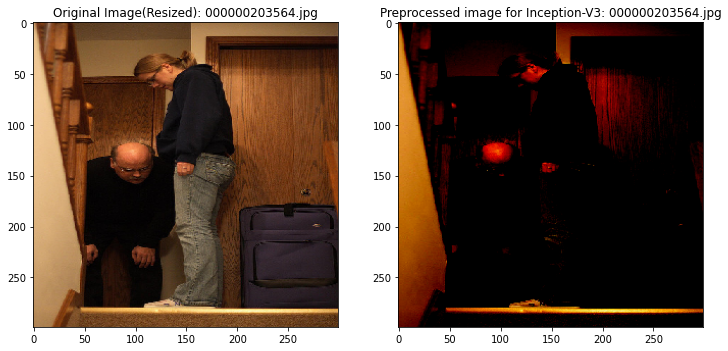

In [20]:
## test out the preprocessing function on one image
##     while calling fuction set debug flag to true to display the original and preprocessed images
i = 0
for key in descriptions.keys():   ## key is the image name itself without the .jpg
  if i > 0:
    break
  
  imgpath = ''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg'])
  #imgpath = ''.join([IPDIRIMGS, key, '.jpg'])
  print(f"Image path = {imgpath}")
  preproc_img = preprocess_image_for_Incepv3(imgpath, _key=key, _DEBUG=True)
  print(f"Shape after preprocessing = {preproc_img.shape}")
  i += 1

In [21]:
descriptions[ONE_RANDOM_IMAGE]

["A man leaning over as she inspects a woman's shoes.",
 'this is two men standing on some stairs',
 'Man standing in front of a woman next to a suitcase. ',
 'a person standing and a person looking down',
 'a man kneeling down looking at a ladies shoes']

### NOTE: Changed code to check if the file exists coz
### description dict is from the full annotations data
### but i split the images into 5k subsets

In [22]:
os.path.isfile(''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg']))

True

In [23]:
## verify count found = 5000
found = 0
for key in descriptions.keys():
  if os.path.isfile(''.join([IPDIRIMGS, key, '.jpg'])) :
    found += 1
print(found)

5000


In [24]:
## actually encode the images and capture entries in dictionary with key as the filename only without the full path or the .jpg extension
##     using same key as the hashmap for captions uses

In [ ]:
## sending all the images
start_time = time.time()
print(f"Started at: {datetime.datetime.now().strftime('%H:%M:%S')}")
img_encodings = {}
idx = 0
for img_filename_only in descriptions.keys():
  if False:  ## debugging
    if idx > 1:
      break
  if os.path.isfile(''.join([IPDIRIMGS, img_filename_only, '.jpg'])):
    img_encodings[img_filename_only] = encode_image(''.join([IPDIRIMGS, img_filename_only, '.jpg']))
    idx += 1
    if idx % 200 == 1:
      print(f'Count of images encoded = {idx}')

print(f"Encoded {idx} images; total time taken = {time.time()-start_time} seconds")

Started at: 14:48:29
Count of images encoded = 1
Count of images encoded = 201
Count of images encoded = 401


In [ ]:
len(img_encodings)  ## should be number of images i.e. 5000

In [ ]:
OPDIR

In [ ]:
## pickle the data
with open(OPDIR+'train2017_subset_5k_20000_25000_images_encoded_features_pickled_1.pkl', 'wb') as handle:
  pickle.dump(img_encodings, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Pickling done")

print(f"Size of pickled data = {sys.getsizeof(img_encodings)} bytes")

In [ ]:
img_encodings[ONE_RANDOM_IMAGE]

In [ ]:
del img_encodings

In [ ]:
## reload from picked file
if True:
  with open(OPDIR+'train2017_subset_5k_20000_25000_images_encoded_features_pickled_1.pkl', 'rb') as handle:
    img_encodings = pickle.load(handle)

#img_encodings

In [ ]:
img_encodings[ONE_RANDOM_IMAGE]

## Process the 25000 - 30000 subset - PENDING

In [ ]:
!ls '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/'

In [ ]:
IPDIRIMGS = '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_25000_30000/'
ONE_RANDOM_IMAGE = '000000001059'   ## do not put the .jpg
os.path.isfile(''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg']))

In [ ]:
## test out the preprocessing function on one image
##     while calling fuction set debug flag to true to display the original and preprocessed images
i = 0
for key in descriptions.keys():   ## key is the image name itself without the .jpg
  if i > 0:
    break
  
  imgpath = ''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg'])
  #imgpath = ''.join([IPDIRIMGS, key, '.jpg'])
  print(f"Image path = {imgpath}")
  preproc_img = preprocess_image_for_Incepv3(imgpath, _key=key, _DEBUG=True)
  print(f"Shape after preprocessing = {preproc_img.shape}")
  i += 1

In [ ]:
descriptions[ONE_RANDOM_IMAGE]

### NOTE: Changed code to check if the file exists coz
### description dict is from the full annotations data
### but i split the images into 5k subsets

In [ ]:
os.path.isfile(''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg']))

In [ ]:
## verify count found = 5000
found = 0
for key in descriptions.keys():
  if os.path.isfile(''.join([IPDIRIMGS, key, '.jpg'])) :
    found += 1
print(found)

In [ ]:
## actually encode the images and capture entries in dictionary with key as the filename only without the full path or the .jpg extension
##     using same key as the hashmap for captions uses

In [ ]:
## sending all the images
start_time = time.time()
print(f"Started at: {datetime.datetime.now().strftime('%H:%M:%S')}")
img_encodings = {}
idx = 0
for img_filename_only in descriptions.keys():
  if False:  ## debugging
    if idx > 1:
      break
  if os.path.isfile(''.join([IPDIRIMGS, img_filename_only, '.jpg'])):
    img_encodings[img_filename_only] = encode_image(''.join([IPDIRIMGS, img_filename_only, '.jpg']))
    idx += 1
    if idx % 200 == 1:
      print(f'Count of images encoded = {idx}')

print(f"Encoded {idx} images; total time taken = {time.time()-start_time} seconds")

In [ ]:
len(img_encodings)  ## should be number of images i.e. 5000

In [ ]:
OPDIR

In [ ]:
## pickle the data
with open(OPDIR+'train2017_subset_5k_25000_30000_images_encoded_features_pickled_1.pkl', 'wb') as handle:
  pickle.dump(img_encodings, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Pickling done")

print(f"Size of pickled data = {sys.getsizeof(img_encodings)} bytes")

In [ ]:
img_encodings[ONE_RANDOM_IMAGE]

In [ ]:
del img_encodings

In [ ]:
## reload from picked file
if True:
  with open(OPDIR+'train2017_subset_5k_25000_30000_images_encoded_features_pickled_1.pkl', 'rb') as handle:
    img_encodings = pickle.load(handle)

#img_encodings

In [ ]:
img_encodings[ONE_RANDOM_IMAGE]

## Process the 30000 - 35000 subset - PENDING

In [ ]:
!ls '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/'

In [ ]:
IPDIRIMGS = '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_30000_35000/'
ONE_RANDOM_IMAGE = '000000001059'   ## do not put the .jpg
os.path.isfile(''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg']))

In [ ]:
## test out the preprocessing function on one image
##     while calling fuction set debug flag to true to display the original and preprocessed images
i = 0
for key in descriptions.keys():   ## key is the image name itself without the .jpg
  if i > 0:
    break
  
  imgpath = ''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg'])
  #imgpath = ''.join([IPDIRIMGS, key, '.jpg'])
  print(f"Image path = {imgpath}")
  preproc_img = preprocess_image_for_Incepv3(imgpath, _key=key, _DEBUG=True)
  print(f"Shape after preprocessing = {preproc_img.shape}")
  i += 1

In [ ]:
descriptions[ONE_RANDOM_IMAGE]

### NOTE: Changed code to check if the file exists coz
### description dict is from the full annotations data
### but i split the images into 5k subsets

In [ ]:
os.path.isfile(''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg']))

In [ ]:
## verify count found = 5000
found = 0
for key in descriptions.keys():
  if os.path.isfile(''.join([IPDIRIMGS, key, '.jpg'])) :
    found += 1
print(found)

In [ ]:
## actually encode the images and capture entries in dictionary with key as the filename only without the full path or the .jpg extension
##     using same key as the hashmap for captions uses

In [ ]:
## sending all the images
start_time = time.time()
print(f"Started at: {datetime.datetime.now().strftime('%H:%M:%S')}")
img_encodings = {}
idx = 0
for img_filename_only in descriptions.keys():
  if False:  ## debugging
    if idx > 1:
      break
  if os.path.isfile(''.join([IPDIRIMGS, img_filename_only, '.jpg'])):
    img_encodings[img_filename_only] = encode_image(''.join([IPDIRIMGS, img_filename_only, '.jpg']))
    idx += 1
    if idx % 200 == 1:
      print(f'Count of images encoded = {idx}')

print(f"Encoded {idx} images; total time taken = {time.time()-start_time} seconds")

In [ ]:
len(img_encodings)  ## should be number of images i.e. 5000

In [ ]:
OPDIR

In [ ]:
## pickle the data
with open(OPDIR+'train2017_subset_5k_30000_35000_images_encoded_features_pickled_1.pkl', 'wb') as handle:
  pickle.dump(img_encodings, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Pickling done")

print(f"Size of pickled data = {sys.getsizeof(img_encodings)} bytes")

In [ ]:
img_encodings[ONE_RANDOM_IMAGE]

In [ ]:
del img_encodings

In [ ]:
## reload from picked file
if True:
  with open(OPDIR+'train2017_subset_5k_30000_35000_images_encoded_features_pickled_1.pkl', 'rb') as handle:
    img_encodings = pickle.load(handle)

#img_encodings

In [ ]:
img_encodings[ONE_RANDOM_IMAGE]

## Process the 35000 - 40000 subset - PENDING

In [ ]:
!ls '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/'

In [ ]:
IPDIRIMGS = '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_35000_40000/'
ONE_RANDOM_IMAGE = '000000001059'   ## do not put the .jpg
os.path.isfile(''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg']))

In [ ]:
## test out the preprocessing function on one image
##     while calling fuction set debug flag to true to display the original and preprocessed images
i = 0
for key in descriptions.keys():   ## key is the image name itself without the .jpg
  if i > 0:
    break
  
  imgpath = ''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg'])
  #imgpath = ''.join([IPDIRIMGS, key, '.jpg'])
  print(f"Image path = {imgpath}")
  preproc_img = preprocess_image_for_Incepv3(imgpath, _key=key, _DEBUG=True)
  print(f"Shape after preprocessing = {preproc_img.shape}")
  i += 1

In [ ]:
descriptions[ONE_RANDOM_IMAGE]

### NOTE: Changed code to check if the file exists coz
### description dict is from the full annotations data
### but i split the images into 5k subsets

In [ ]:
os.path.isfile(''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg']))

In [ ]:
## verify count found = 5000
found = 0
for key in descriptions.keys():
  if os.path.isfile(''.join([IPDIRIMGS, key, '.jpg'])) :
    found += 1
print(found)

In [ ]:
## actually encode the images and capture entries in dictionary with key as the filename only without the full path or the .jpg extension
##     using same key as the hashmap for captions uses

In [ ]:
## sending all the images
start_time = time.time()
print(f"Started at: {datetime.datetime.now().strftime('%H:%M:%S')}")
img_encodings = {}
idx = 0
for img_filename_only in descriptions.keys():
  if False:  ## debugging
    if idx > 1:
      break
  if os.path.isfile(''.join([IPDIRIMGS, img_filename_only, '.jpg'])):
    img_encodings[img_filename_only] = encode_image(''.join([IPDIRIMGS, img_filename_only, '.jpg']))
    idx += 1
    if idx % 200 == 1:
      print(f'Count of images encoded = {idx}')

print(f"Encoded {idx} images; total time taken = {time.time()-start_time} seconds")

In [ ]:
len(img_encodings)  ## should be number of images i.e. 5000

In [ ]:
OPDIR

In [ ]:
## pickle the data
with open(OPDIR+'train2017_subset_5k_35000_40000_images_encoded_features_pickled_1.pkl', 'wb') as handle:
  pickle.dump(img_encodings, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Pickling done")

print(f"Size of pickled data = {sys.getsizeof(img_encodings)} bytes")

In [ ]:
img_encodings[ONE_RANDOM_IMAGE]

In [ ]:
del img_encodings

In [ ]:
## reload from picked file
if True:
  with open(OPDIR+'train2017_subset_5k_35000_40000_images_encoded_features_pickled_1.pkl', 'rb') as handle:
    img_encodings = pickle.load(handle)

#img_encodings

In [ ]:
img_encodings[ONE_RANDOM_IMAGE]

## Process the 40000 - 45000 subset - PENDING

In [ ]:
!ls '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/'

In [ ]:
IPDIRIMGS = '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_40000_45000/'
ONE_RANDOM_IMAGE = '000000001059'   ## do not put the .jpg
os.path.isfile(''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg']))

In [ ]:
## test out the preprocessing function on one image
##     while calling fuction set debug flag to true to display the original and preprocessed images
i = 0
for key in descriptions.keys():   ## key is the image name itself without the .jpg
  if i > 0:
    break
  
  imgpath = ''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg'])
  #imgpath = ''.join([IPDIRIMGS, key, '.jpg'])
  print(f"Image path = {imgpath}")
  preproc_img = preprocess_image_for_Incepv3(imgpath, _key=key, _DEBUG=True)
  print(f"Shape after preprocessing = {preproc_img.shape}")
  i += 1

In [ ]:
descriptions[ONE_RANDOM_IMAGE]

### NOTE: Changed code to check if the file exists coz
### description dict is from the full annotations data
### but i split the images into 5k subsets

In [ ]:
os.path.isfile(''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg']))

In [ ]:
## verify count found = 5000
found = 0
for key in descriptions.keys():
  if os.path.isfile(''.join([IPDIRIMGS, key, '.jpg'])) :
    found += 1
print(found)

In [ ]:
## actually encode the images and capture entries in dictionary with key as the filename only without the full path or the .jpg extension
##     using same key as the hashmap for captions uses

In [ ]:
## sending all the images
start_time = time.time()
print(f"Started at: {datetime.datetime.now().strftime('%H:%M:%S')}")
img_encodings = {}
idx = 0
for img_filename_only in descriptions.keys():
  if False:  ## debugging
    if idx > 1:
      break
  if os.path.isfile(''.join([IPDIRIMGS, img_filename_only, '.jpg'])):
    img_encodings[img_filename_only] = encode_image(''.join([IPDIRIMGS, img_filename_only, '.jpg']))
    idx += 1
    if idx % 200 == 1:
      print(f'Count of images encoded = {idx}')

print(f"Encoded {idx} images; total time taken = {time.time()-start_time} seconds")

In [ ]:
len(img_encodings)  ## should be number of images i.e. 5000

In [ ]:
OPDIR

In [ ]:
## pickle the data
with open(OPDIR+'train2017_subset_5k_40000_45000_images_encoded_features_pickled_1.pkl', 'wb') as handle:
  pickle.dump(img_encodings, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Pickling done")

print(f"Size of pickled data = {sys.getsizeof(img_encodings)} bytes")

In [ ]:
img_encodings[ONE_RANDOM_IMAGE]

In [ ]:
del img_encodings

In [ ]:
## reload from picked file
if True:
  with open(OPDIR+'train2017_subset_5k_40000_45000_images_encoded_features_pickled_1.pkl', 'rb') as handle:
    img_encodings = pickle.load(handle)

#img_encodings

In [ ]:
img_encodings[ONE_RANDOM_IMAGE]

## Process the 45000 - 50000 subset - PENDING

In [ ]:
!ls '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/'

In [ ]:
IPDIRIMGS = '/content/gdrive/My Drive/ThesisStoryGen/Data/coco_train2017_wget_1/coco_test2017_subset_45000_50000/'
ONE_RANDOM_IMAGE = '000000001059'   ## do not put the .jpg
os.path.isfile(''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg']))

In [ ]:
## test out the preprocessing function on one image
##     while calling fuction set debug flag to true to display the original and preprocessed images
i = 0
for key in descriptions.keys():   ## key is the image name itself without the .jpg
  if i > 0:
    break
  
  imgpath = ''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg'])
  #imgpath = ''.join([IPDIRIMGS, key, '.jpg'])
  print(f"Image path = {imgpath}")
  preproc_img = preprocess_image_for_Incepv3(imgpath, _key=key, _DEBUG=True)
  print(f"Shape after preprocessing = {preproc_img.shape}")
  i += 1

In [ ]:
descriptions[ONE_RANDOM_IMAGE]

### NOTE: Changed code to check if the file exists coz
### description dict is from the full annotations data
### but i split the images into 5k subsets

In [ ]:
os.path.isfile(''.join([IPDIRIMGS, ONE_RANDOM_IMAGE, '.jpg']))

In [ ]:
## verify count found = 5000
found = 0
for key in descriptions.keys():
  if os.path.isfile(''.join([IPDIRIMGS, key, '.jpg'])) :
    found += 1
print(found)

In [ ]:
## actually encode the images and capture entries in dictionary with key as the filename only without the full path or the .jpg extension
##     using same key as the hashmap for captions uses

In [ ]:
## sending all the images
start_time = time.time()
print(f"Started at: {datetime.datetime.now().strftime('%H:%M:%S')}")
img_encodings = {}
idx = 0
for img_filename_only in descriptions.keys():
  if False:  ## debugging
    if idx > 1:
      break
  if os.path.isfile(''.join([IPDIRIMGS, img_filename_only, '.jpg'])):
    img_encodings[img_filename_only] = encode_image(''.join([IPDIRIMGS, img_filename_only, '.jpg']))
    idx += 1
    if idx % 200 == 1:
      print(f'Count of images encoded = {idx}')

print(f"Encoded {idx} images; total time taken = {time.time()-start_time} seconds")

In [ ]:
len(img_encodings)  ## should be number of images i.e. 5000

In [ ]:
OPDIR

In [ ]:
## pickle the data
with open(OPDIR+'train2017_subset_5k_45000_50000_images_encoded_features_pickled_1.pkl', 'wb') as handle:
  pickle.dump(img_encodings, handle, protocol=pickle.HIGHEST_PROTOCOL)
print(f"Pickling done")

print(f"Size of pickled data = {sys.getsizeof(img_encodings)} bytes")

In [ ]:
img_encodings[ONE_RANDOM_IMAGE]

In [ ]:
del img_encodings

In [ ]:
## reload from picked file
if True:
  with open(OPDIR+'xxxxx.pkl', 'rb') as handle:
    img_encodings = pickle.load(handle)

#img_encodings

In [ ]:
img_encodings[ONE_RANDOM_IMAGE]

## Process the xxxx - xxx subset - PENDING